# Problém batohu
Základ problému
Je dáno

- celé číslo `n` (počet věcí)
- celé číslo `M` (kapacita batohu)
- konečná množina `V = {v1, v2, ... ,vn }` (hmotnosti věcí)
- konečná množina `C = {c1, c2, ... ,cn }` (ceny věcí)

In [1]:
instanceNList = [4, 10, 15, 20, 22, 25, 27, 30, 32, 35, 37, 40]
instanceSet = set()
instanceN = set([4, 10, 15, 20, 22, 25, 27, 30, 32, 35, 37, 40])

### Implementace problému batohu 

In [2]:
import enum
import numpy as np
from time import time

class Method(enum.Enum):
    """Enumerates types of methods"""
#     BF = 1    # Brute Force method
    BAB = 2   # Branch and Bound method
    G = 3     # Greedy method
    R = 4     # Redux method
    DHBP = 5  # Dynamic Heuristics By Price method
#     FPTAS_0_3 = 6 # FPTAS method with e = 0.03
#     FPTAS_1 = 7 # FPTAS method with e = 0.1
#     FPTAS_3 = 8 # FPTAS method with e = 0.3
#     FPTAS_5 = 9 # FPTAS method with e = 0.5
#     FPTAS_7 = 10 # FPTAS method with e = 0.7

def timer(func):
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        print(f'Function {func.__name__!r} executed in {(t2-t1):.4f}s')
        return result
    return wrap_func

def quietTimer(func):
    def wrapFunc(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        
        # set 'self.executionTime' to measured time
        args[0].executionTime = t2-t1

        return result
    return wrapFunc

Definice Třídy Knapsack řešící problém a uchovávající výsledek

In [3]:
import math
import copy
import itertools


class Knapsack:
    def __init__(self, initString):
        arr = initString.split()
        decisionProblem = int(arr[0]) < 0
        items = arr[4:] if decisionProblem else arr[3:]
        
        self.id = int(arr[0])
        self.n = int(arr[1])
        self.M = int(arr[2])
        self.B = int(arr[3]) if decisionProblem else None
        self.weights = list(map(lambda x: int(x), items[::2]))
        self.prices = list(map(lambda x: int(x), items[1::2]))
        self.solution = None
        self.solutionPrice = None
        self.decisionSolution = None
        self.initString = initString
        self.outputString = None
        self.stepsToSolve = None
        self.executionTime = None
        
    def __str__ (self):
        res = "KNAPSACK " + str(self.id) + "\n"
        res += "-----------------------------------" + "\n"
        res += "n = " + str(self.n) + "\tM = " + str(self.M) + "\tB = " + (str(self.B) if self.B else "--") + "\n"
        
        for (i, x) in enumerate(self.weights):
            res += "#" + str(i) + "\t" + str(x) + "\t" + str(self.prices[i]) + "\t\t" + (str(self.solution[i]) if self.solution is not None else "") + "\n"
        res += "-----------------------------------" + "\n"
        res += "CONSTRUCTIVE PROBLEM SOLUTION:\t" + (str(self.solutionPrice) if self.solutionPrice is not None else "--") + "\n"
        res += "DECISION PROBLEM SOLUTIONS:\t#" + (str(len(self.decisionSolution)) if self.decisionSolution is not None else "--") + "\n"
        res += "-----------------------------------" + "\n"
        
        return res
    
    def createOutputString(self):
        self.outputString = str(abs(self.id)) + " " + str(self.n) + " " + str(self.solutionPrice)
        if self.solution is None:
            return
        if len(self.solution) == 0:
            self.solution = [0] * self.n
        for s in self.solution:
            self.outputString += " " + str(s)    
    
    def __repr__ (self):
        self.createOutputString()
        return self.outputString if self.outputString is not None else "--"
    
    def getSolution(self):
        return self.__repr__()
    
    def getStepsToSolve(self):
        return self.stepsToSolve
    
    def getItemsInfo(self, arr):
        finalWeight = 0
        finalPrice = 0
        
        for (i, inKnapsack) in enumerate(arr):
            finalWeight += self.weights[i] if inKnapsack else 0
            finalPrice += self.prices[i] if inKnapsack else 0
            
        return (finalWeight, finalPrice)
    
    def getB(self):
        return self.B
    
    def solutionIsEmpty(self):
        return len(self.decisionSolution) == 0
    
    def getConstructiveSolution(self):
        return self.solutionPrice
    
    def getExecutionTime(self):
        return self.executionTime
    
    ######################
    # BRUTE FORCE
    ######################
    
    # Brute Force for constructive 0/1 problem
    def bruteForceAux(self, W, wt, val, n):
        # Base Case
        if n == 0 or W == 0:
            return (0, [])

        if (wt[n-1] > W):
            x = self.bruteForceAux(W, wt, val, n-1)
            path = x[1]
            path.append(0)
            return (x[0], path)

        else:
            x = self.bruteForceAux(W-wt[n-1], wt, val, n-1)
            y = self.bruteForceAux(W, wt, val, n-1)
            if x[0] + val[n-1] > y[0]:
                path = x[1]
                path.append(1)
                return (x[0] + val[n-1], path)
            else:
                path = y[1]
                path.append(0)
                return (y[0], path)
    
    def bruteForceSolve(self):
        x =  self.bruteForceAux(self.M, self.weights, self.prices, self.n)
        self.solution = x[1]
        self.solutionPrice = x[0]
        self.createOutputString()
        return x
    
    # Brute Force for decision 0/1 problem
    def decisionBruteForceSolve(self):
        self.solutionPrice = 0
        self.decisionSolution = []
        self.stepsToSolve = 2**self.n
        for i in range(2**self.n):
            x = ("{0:0" + str(self.n) + "b}").format(i)
            finalPrice = 0
            finalWeight = 0
            for (j, b) in enumerate(x):
                if int(b):
                    finalPrice += int(self.prices[j])
                    finalWeight += int(self.weights[j])
            if finalWeight <= self.M:
                if finalPrice > self.solutionPrice:
                    self.solutionPrice = finalPrice
                    self.solution = list(x)
                if finalPrice >= self.B:
                    self.decisionSolution.append(list(x))
        # no solution found
        if self.solution is None:
            self.solution = []
        
        self.createOutputString()
        return self.decisionSolution
    
    ######################
    # BRANCH AND BOUND
    ######################

    def returnSecondEl(self, e):
        return e[1]
        
    def babAux(self, n, M, accPrice, weights, prices, acc):
        # stop conditions
        if n == 0:
            self.stepsToSolve += 1
            if M >= 0 and accPrice > self.solutionPrice:
                self.solutionPrice = accPrice
            return
        
        # following subtree won't satisfy price boundary 
        if accPrice + sum(prices) < self.solutionPrice:
            return
        
        # item doesn't fit into knapsack - weight boundary
        if (weights[n-1] > M):
            self.babAux(n - 1, M, accPrice, weights[:n - 1], prices[:n - 1], acc + [0])
            return
        
        # item fits in knapsack
        else:
            # item fits and is added into knapsack
            self.babAux(n - 1, M - weights[n - 1], accPrice + prices[n - 1], weights[:n - 1], prices[:n - 1], acc + [1])
            # item fits but isn't added into knapsack
            self.babAux(n - 1, M, accPrice, weights[:n - 1], prices[:n - 1], acc + [0])

    @quietTimer    
    def bab(self):
        self.solutionPrice = 0
        self.decisionSolution = []
        self.stepsToSolve = 0
        
        self.babAux(self.n, self.M, 0, self.weights, self.prices, [])
        
        return self.solutionPrice
        
    ######################
    # GREEDY HEURISTICS
    ######################
    
    @quietTimer
    def greedy(self):
        elements = []
        M = self.M
        
        for (i, x) in enumerate(self.prices):
            d = {
                'i': i,
                'p': x,
                'w': self.weights[i],
                'r': x / self.weights[i],
                's': 0
            }
            elements.append(d)
        
        elements.sort(key=lambda x: x['r'], reverse=True)
        
#         print(elements)
        
        self.stepsToSolve = len(elements)
        solution = 0
        for (i, x) in enumerate(elements):
            # if fits to knapsack, add it in
            if x['w'] <= M:
                x['s'] = 1
                M -= x['w']
                solution += x['p']
                
        elements.sort(key=lambda x: x['i'])
#         solutionList = list(map(lambda x: x["s"], elements))
        self.solutionPrice = solution
                
        return solution
            
    ######################
    # REDUX HEURISITICS
    ######################
    
    @quietTimer
    def redux(self):
        greedyPrice = self.greedy()
        
        # find highest price than fits into knapsack
        highestPrice = 0
        for (i, x) in enumerate(self.prices):
            # if fits into Knapsack and is maximum so far
            if self.weights[i] <= self.M and x > highestPrice:
                highestPrice = x
        
        self.solutionPrice = max(greedyPrice, highestPrice)
        
        return self.solutionPrice
    
    ######################
    # DYNAMIC HEURISITICS BY PRICE
    ######################
    
    def dhbpIsInTable(self, i, c):
        return (True if c in self.dhbpTable[i].keys() else False)
    
    def dhbpAux(self, i, c):
        self.stepsToSolve += 1
        
        # check if already in table
        if self.dhbpIsInTable(i, c):
            return self.dhbpTable[i][c]
        
        # trivial Case
        if i == 0 and c == 0:
            return 0
        
        # impossible case
        if i == 0:
            return np.inf
        
        # recursive definition
        minW = min(self.dhbpAux(i - 1, c), self.dhbpAux(i - 1, c - self.prices[i - 1]) + self.weights[i - 1])
        
        # store to table
        self.dhbpTable[i][c] = minW
        
        return minW
    
    @quietTimer
    def dhbp(self):
        self.stepsToSolve = 0
        
        # create empty table
        self.dhbpTable = dict()
        for i in range(self.n + 1):
            self.dhbpTable[i] = dict()
        
        totalSum = sum(self.prices)
        
        # get highest price lower than M
        for i in range(totalSum, 0, -1):
            res = self.dhbpAux(self.n, i)
            if res <= self.M:
#                 print("weight:", res, ", price:", i)
                self.solutionPrice = i
                return i
        
        self.solutionPrice = 0
        return 0
        
    ######################
    # FPTAS
    ######################
    
    @quietTimer
    def fptas(self, e):
        
        C = max(self.prices)
        K = C * e / self.n
        
        # it would slowed down the computation because it would increase all prices
        if K <= 1:
            self.solutionPrice = math.floor(result * K)
            return self.dhbp()
        
        # create new prices
        ci = []
        originalPrices = copy.deepcopy(self.prices)
        for p in self.prices:
            ci.append(math.floor(p/K))
            
        self.prices = ci
        
        # do the computation with dhbp
        result = self.dhbp()
        
        # store original prices
        self.prices = originalPrices
        
        self.solutionPrice = math.floor(result * K)
        
        return math.floor(result * K)
        

### Generátor sad instancí

In [4]:
import subprocess
import os.path

class SetGenerator:
    def __init__(self):
        pass
    
    def createDir(self, name):
        subprocess.run(["mkdir", "-p", name])
        
    def createValidationData(self, instances):
        inst = instances.split("\n")[:-1]
        res = []
        for i in inst:
            print(">",i)
            k = Knapsack(i)
            k.bab()
            res.append(k.__repr__())
            
        return "\n".join(res)
        
    def createSet(self, setName, instNum, W, C, m=None, w=None, c=None, k=None, recreate=False):
        # create new directory; add new set
        instanceSet.add(setName)
        self.createDir(setName)
        
        # prepare arguments
        l = []
        if m is not None:
            l.append("-m")
            l.append(str(m))
        if w is not None:
            l.append("-w")
            l.append(w)
        if c is not None:
            l.append("-c")
            l.append(c)
        if k is not None:
            l.append("-k")
            l.append(str(k))
        
        # execute and save generated instances
        for n in instanceNList:
            f = open(setName + "/" + setName + str(n) + "_inst.dat", "w")
            subprocess.run(["./gen-1.2/gen/kg2", "-n", str(n), "-N", str(instNum), "-W", str(W), "-C", str(C), *l], stdout=f)
            
            f.close()
            f = open(setName + "/" + setName + str(n) + "_inst.dat", "r")
            instances = f.read()
            f.close()
            
            if not os.path.exists(setName + "/" + setName + str(n) + "_sol.dat") or recreate:
                f2 = open(setName + "/" + setName + str(n) + "_sol.dat", "w")
                f2.write(self.createValidationData(instances))
                f2.close()
        
    def createFirstSet(self, recreate=False):
        self.createSet("FS", 50, 80, 50, k=2, recreate=recreate)
        
    def pilotExMaxWeight(self, recreate=False):
        self.createSet("P_W0", 100, 50, 100, recreate=recreate)
        self.createSet("P_W1", 100, 100, 100, recreate=recreate)
        self.createSet("P_W2", 100, 200, 100, recreate=recreate)
        self.createSet("P_W3", 100, 400, 100, recreate=recreate)
        self.createSet("P_W4", 100, 800, 100, recreate=recreate)
        
        

In [5]:
sg = SetGenerator()
sg.pilotExMaxWeight()

Definice třídy InstanceManager, která spouští a kontroluje řešení jednotlivých instancí batohu pro určité *n*

In [6]:
from statistics import mean

class InstanceManager:
    def __init__(self, stringInstances, stringInstancesSolutions):
        self.instancesStrings = stringInstances.split("\n")[:-1] # last is empty line

        
        self.instancesSolutions = []
        for _ in range(int(self.instancesStrings[-1].split(" ")[0])):
            self.instancesSolutions.append([])
        self.stepsOfInstances = None
        self.timeOfInstances = None
        self.faultOfInstances = None
        
        self.correctSolutionPrice = []
        
        for solution in stringInstancesSolutions.split("\n"):
            if solution == '':
                continue
            idOfInstance = int(solution.split(' ')[0])
            self.correctSolutionPrice.append(int(solution.split(' ')[2]))
            self.instancesSolutions[idOfInstance - 1].append(int(solution.split(' ')[2]))
            
    def getStepsOfInstances(self):
        return self.stepsOfInstances
    
    def getTimeOfInstances(self):
        return self.timeOfInstances
    
    def getFaultOfInstances(self):
        return self.faultOfInstances
            
    def checkInstances(self, method):
        fail = 0
        self.stepsOfInstances = []
        self.timeOfInstances = []
        self.faultOfInstances = []
        
        for (i, instanceString) in enumerate(self.instancesStrings):
            knapsackId = int(instanceString.split(' ')[0])
            inst = Knapsack(instanceString)
            
            # solve instance with chosen method
            if method == Method.BAB:
                inst.bab()
            elif method == Method.G:
                inst.greedy()
            elif method == Method.R:
                inst.redux()
            elif method == Method.DHBP:
                inst.dhbp()
#             elif method == Method.FPTAS_0_3:
#                 inst.fptas(0.03)
#             elif method == Method.FPTAS_1:
#                 inst.fptas(0.1)
#             elif method == Method.FPTAS_3:
#                 inst.fptas(0.3)
#             elif method == Method.FPTAS_5:
#                 inst.fptas(0.5)
#             elif method == Method.FPTAS_7:
#                 inst.fptas(0.7)
            
            self.stepsOfInstances.append(inst.getStepsToSolve())
            self.timeOfInstances.append(inst.getExecutionTime())
            
            # counter of computed instances
            if (i + 1) % 10 == 0:
                print("#{}".format(i + 1), end=", ")
            
            if inst.getConstructiveSolution() not in self.instancesSolutions[i]:
                self.faultOfInstances.append((self.instancesSolutions[knapsackId - 1][0] - inst.getConstructiveSolution()) / float(self.instancesSolutions[knapsackId - 1][0]))
                fail += 1
            else:
                self.faultOfInstances.append(0)
                
                
        print("\n")
        
        if fail > 0:
            print("FAILS: {}/{}".format(str(fail), "500"))
        else:
            print("SUCCESS")
            
        avgStep = mean(self.stepsOfInstances)
        avgExecutionTime = mean(self.timeOfInstances)
        avgFault = mean(list(map(abs, self.faultOfInstances)))
        print("Average number of steps: {}".format(round(avgStep, 2)))
        print("Average execution time: {}".format(round(avgExecutionTime, 6)))
        print("Average fault: {}".format(avgFault))
        print("---------")
        return self.stepsOfInstances


Definice třídy InstanceSetManager ,která řídí spouštění sad o různých velikostech *n*

In [7]:
import os
from pathlib import Path

class InstanceSetManager:
    def __init__ (self, pathToSet):
        self.pathToSet = pathToSet
        self.filesInDirectory = os.listdir(pathToSet)
        self.ns = set()
        for f in self.filesInDirectory:
            n = f.replace(self.pathToSet[:-1], "").replace("_inst.dat", "").replace("_sol.dat", "")
            self.ns.add(int(n))
            
    def solve(self, method, maxN=22):
        for n in sorted(self.ns):
            if n > maxN:
                break
                
            print("---------")
            print("INSTANCES n = {}".format(str(n)))    
            
            instanceFile = self.pathToSet[:-1] + str(n) + "_inst.dat"
            solutionFile = self.pathToSet[:-1] + str(n) + "_sol.dat"
            
            txt = Path(self.pathToSet + instanceFile).read_text()
            txtSol = Path(self.pathToSet + solutionFile).read_text()
            txtSol = txtSol.replace(" \n", "\n")
            manager = InstanceManager(txt, txtSol)
            
            # store number of steps
            steps = manager.checkInstances(method)
            f = open("results/steps/{}{}_{}.txt".format(self.pathToSet[:-1], n, method.name), "w")
            nl = "\n"
            f.write(nl.join(map(lambda x: str(x), steps)) + "\n")
            f.close()
            
            # store execution time
            f2 = open("results/time/{}{}_{}.txt".format(self.pathToSet[:-1], n, method.name), "w")
            nl = "\n"
            f2.write(nl.join(map(lambda x: str(x), manager.getTimeOfInstances())) + "\n")
            f2.close()
            
            # store 
            f3 = open("results/fault/{}{}_{}.txt".format(self.pathToSet[:-1], n, method.name), "w")
            nl = "\n"
            f3.write(nl.join(map(lambda x: str(x), manager.getFaultOfInstances())) + "\n")
            f3.close()
            

## Experimenty
V následujících buňkách se testují jednotlivé metody na jednotlivých sadách a velikostech *n* a verifikuje se správnost řešení.

In [10]:
for setName in ["P_W0", "P_W1", "P_W2", "P_W3", "P_W4"]:
    print(f"==============================================\n\t{setName}\n==============================================")
    for m in [Method.BAB, Method.G, Method.R, Method.DHBP]:
        print(f"======================= {m.name} =======================")
        a = InstanceSetManager(setName + "/")
        a.solve(m, 40)

	P_W0
======================= BAB =======================
---------
INSTANCES n = 4
#10, #20, #30, #40, #50, #60, #70, #80, #90, #100, 

SUCCESS
Average number of steps: 3.31
Average execution time: 9e-06
Average fault: 0
---------
---------
INSTANCES n = 10
#10, #20, #30, #40, #50, #60, #70, #80, #90, #100, 

SUCCESS
Average number of steps: 8.92
Average execution time: 4.9e-05
Average fault: 0
---------
---------
INSTANCES n = 15
#10, #20, #30, #40, #50, #60, #70, #80, #90, #100, 

SUCCESS
Average number of steps: 19.12
Average execution time: 0.00017
Average fault: 0
---------
---------
INSTANCES n = 20
#10, #20, #30, #40, #50, #60, #70, #80, #90, #100, 

SUCCESS
Average number of steps: 43.36
Average execution time: 0.000593
Average fault: 0
---------
---------
INSTANCES n = 22
#10, #20, #30, #40, #50, #60, #70, #80, #90, #100, 

SUCCESS
Average number of steps: 43.66
Average execution time: 0.000762
Average fault: 0
---------
---------
INSTANCES n = 25
#10, #20, #30, #40, #50, #60

#10, #20, #30, #40, #50, #60, #70, #80, #90, #100, 

SUCCESS
Average number of steps: 33002.45
Average execution time: 0.01984
Average fault: 0
---------
---------
INSTANCES n = 27
#10, #20, #30, #40, #50, #60, #70, #80, #90, #100, 

SUCCESS
Average number of steps: 37783.96
Average execution time: 0.022732
Average fault: 0
---------
---------
INSTANCES n = 30
#10, #20, #30, #40, #50, #60, #70, #80, #90, #100, 

SUCCESS
Average number of steps: 47477.88
Average execution time: 0.028925
Average fault: 0
---------
---------
INSTANCES n = 32
#10, #20, #30, #40, #50, #60, #70, #80, #90, #100, 

SUCCESS
Average number of steps: 54246.55
Average execution time: 0.036789
Average fault: 0
---------
---------
INSTANCES n = 35
#10, #20, #30, #40, #50, #60, #70, #80, #90, #100, 

SUCCESS
Average number of steps: 64004.65
Average execution time: 0.042343
Average fault: 0
---------
---------
INSTANCES n = 37
#10, #20, #30, #40, #50, #60, #70, #80, #90, #100, 

SUCCESS
Average number of steps: 73055

IndexError: list index out of range

## Analýza
následující buňka zadefinuje analyzátor uložených dat a v dalších buňkách je spuštěna samotná analýza

In [37]:
import statistics
import matplotlib.pyplot as plt 
import numpy as np

class Analyzer:
    def __init__(self):
        self.results = dict()
        for instanceName in instanceSet:
            self.results[instanceName] = dict()
            for method in Method:
                self.results[instanceName][method.name] = dict()
                for n in instanceN:
                    self.results[instanceName][method.name][n] = dict()
                    for featureName in ["steps", "time", "fault"]:
                        try:
                            f = open("results/{}/{}{}_{}.txt".format(featureName, instanceName, n, method.name), "r")
                            lines = f.readlines()
                            f.close()                   
                            self.results[instanceName][method.name][n][featureName] = list(map(lambda x: float(x), lines))
                        except:
                            self.results[instanceName][method.name][n][featureName] = None

    def computeStatistics(self):
        self.statistics = dict()
        for setKey in self.results.keys():
            self.statistics[setKey] = dict()
            for methodKey in self.results[setKey].keys():
                self.statistics[setKey][methodKey] = dict()
                self.statistics[setKey][methodKey]["time"] = []
                self.statistics[setKey][methodKey]["steps"] = []
                self.statistics[setKey][methodKey]["fault"] = []
                self.statistics[setKey][methodKey]["maxFault"] = []
                for nKey in sorted(self.results[setKey][methodKey].keys()):
                    self.statistics[setKey][methodKey]["time"].append(None if self.results[setKey][methodKey][nKey]["time"] is None else round(statistics.mean(self.results[setKey][methodKey][nKey]["time"]), 6))
                    self.statistics[setKey][methodKey]["steps"].append(None if self.results[setKey][methodKey][nKey]["steps"] is None else round(statistics.mean(self.results[setKey][methodKey][nKey]["steps"]), 6))
                    self.statistics[setKey][methodKey]["fault"].append(None if self.results[setKey][methodKey][nKey]["fault"] is None else round(statistics.mean(self.results[setKey][methodKey][nKey]["fault"]), 6))
                    self.statistics[setKey][methodKey]["maxFault"].append(None if self.results[setKey][methodKey][nKey]["fault"] is None else round(max(self.results[setKey][methodKey][nKey]["fault"]), 6))
            
    def analyze(self):
        
        # compute statistics about mean time, mean steps and mean relative fault
        self.computeStatistics()
        
        print("\n\nAVERAGE EXECUTION FAULT\n")
        
        # plot charts of execution time according to set and method
        for setKey in self.results.keys():
            print("===== {} =====".format(setKey))
            
            # set plots to be plotted
            for methodKey in self.results[setKey].keys():
                print(methodKey)
                print(self.statistics[setKey][methodKey]["time"])
                print("----")
                plt.plot(list(sorted(instanceN)), self.statistics[setKey][methodKey]["time"], label=methodKey)
            
            # plot chart
            plt.xlabel("n")  # add X-axis label
            plt.ylabel("time")  # add Y-axis label
            plt.title("Average execution time of set " + setKey)  # add title
            plt.yscale("log")
            plt.legend(self.results[setKey])
            plt.legend(bbox_to_anchor=(1,1), loc="upper left")
            plt.show()
            
        
        print("\n\nAVERAGE RELATIVE FAULT\n")
            
        # plot charts of average fault according to set and method
        for setKey in self.results.keys():
            print("===== {} =====".format(setKey))
            
            # set plots to be plotted
            for methodKey in self.results[setKey].keys():
                print(methodKey)
                print(self.statistics[setKey][methodKey]["fault"])
                print("----")
                plt.plot(list(sorted(instanceN)), self.statistics[setKey][methodKey]["fault"], label=methodKey)
            
            # plot chart
            plt.xlabel("n")  # add X-axis label
            plt.ylabel("average fault")  # add Y-axis label
            plt.title("Average relative fault of set " + setKey)  # add title
            plt.yscale("log")
            plt.legend(self.results[setKey])
            plt.legend(bbox_to_anchor=(1,1), loc="upper left")
            plt.show()
            
            
        print("\n\nMAXIMUM RELATIVE FAULT\n")
            
        # plot charts of maximum fault according to set and method
        for setKey in self.results.keys():
            print("===== {} =====".format(setKey))
            
            # set plots to be plotted
            for methodKey in self.results[setKey].keys():
                print(methodKey)
                print(self.statistics[setKey][methodKey]["maxFault"])
                print("----")
                plt.plot(list(sorted(instanceN)), self.statistics[setKey][methodKey]["maxFault"], label=methodKey)
            
            # plot chart
            plt.xlabel("n")  # add X-axis label
            plt.ylabel("max fault")  # add Y-axis label
            plt.title("Maximum relative fault of set " + setKey)  # add title
            plt.yscale("log")
            plt.legend(self.results[setKey])
            plt.legend(bbox_to_anchor=(1,1), loc="upper left")
            plt.show()
        



AVERAGE EXECUTION FAULT

===== FS =====
BAB
[9e-06, 4.6e-05, 0.000186, 0.000613, 0.000803, 0.001703, 0.002896, 0.006326, 0.007353, 0.024779, 0.036964, 0.071314]
----
G
[4e-06, 9e-06, 1.3e-05, 1.8e-05, 1.7e-05, 2e-05, 2.2e-05, 2.5e-05, 2.6e-05, 2.7e-05, 3e-05, 3.2e-05]
----
R
[7e-06, 1e-05, 1.4e-05, 2.1e-05, 2.3e-05, 2.4e-05, 2.5e-05, 2.8e-05, 2.9e-05, 3.3e-05, 3.3e-05, 3.5e-05]
----
DHBP
[0.000251, 0.001533, 0.003828, 0.006473, 0.008094, 0.012547, 0.013606, 0.015024, 0.019533, 0.021023, 0.026253, 0.02879]
----


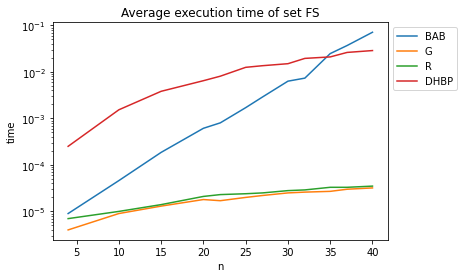



AVERAGE RELATIVE FAULT

===== FS =====
BAB
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
----
G
[0.007538, 0.004542, 0.002904, 0.002102, 0.000806, 0.001715, 0.001247, 0.001316, 0.001719, 0.001399, 0.001315, 0.001014]
----
R
[0.007538, 0.004542, 0.002904, 0.002102, 0.000806, 0.001715, 0.001247, 0.001316, 0.001719, 0.001399, 0.001315, 0.001014]
----
DHBP
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
----


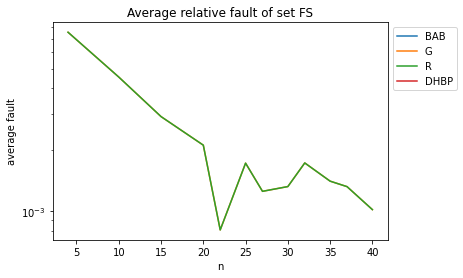



MAXIMUM RELATIVE FAULT

===== FS =====
BAB
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
----
G
[0.146067, 0.048583, 0.028269, 0.024793, 0.00703, 0.015901, 0.012324, 0.009763, 0.012547, 0.009524, 0.007626, 0.007663]
----
R
[0.146067, 0.048583, 0.028269, 0.024793, 0.00703, 0.015901, 0.012324, 0.009763, 0.012547, 0.009524, 0.007626, 0.007663]
----
DHBP
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
----


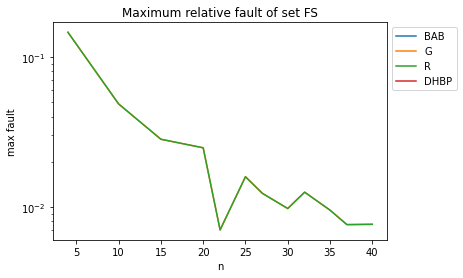

In [38]:
a = Analyzer()
a.analyze()